<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the last step in the split workflow on Terra

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

In [21]:
import sys
from pathlib import Path
import time
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Thu Mar 30 07:27:16 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Installing Packages

In [22]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 

In [23]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_download_path = f"{curr_dir}/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_path = f"{curr_dir}/dcmqi-1.2.5-linux"

# !wget -O $dcmqi_download_path $dcmqi_release_url

# !tar -xvf $dcmqi_download_path 

# !mv $dcmqi_path/bin/* /bin
# !rm -r $dcmqi_download_path $dcmqi_path

In [24]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Parameters

In [37]:
csvFilePath=''
inferenceNiftiFilePath=''

###Extracting Inference NIFTI files

In [26]:
import shutil
import glob
import os
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass

#Get the file path of the inferenceNiftiFiles

#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4'

!lz4 -d {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4 -c | tar xvf -

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446.nii.gz.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524.nii.gz

###Reading CSV File containing s5cmd Urls

In [27]:
import sys
import time
import pandas as pd
from pathlib import Path

In [28]:
#get the path of the zip file containing csv file in the current working directory
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob

#zip_file_path = glob.glob('*.zip')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'

start_time = time.time()
#cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.28446507453918457  seconds


###Functions

In [29]:
try:
  shutil.rmtree(f'itkimage2segimage')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')

In [30]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [31]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [32]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole.json')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json

--2023-03-30 07:27:22--  https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80391 (79K) [text/plain]
Saving to: ‘dicomseg_metadata_whole.json’

dicomseg_metadata_w 100%[===================>]  78.51K  --.-KB/s    in 0.009s  

2023-03-30 07:27:23 (8.70 MB/s) - ‘dicomseg_metadata_whole.json’ saved [80391/80391]



In [33]:
def itkimage2segimage(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 


      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.gz.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.gz')
      inference_list = []
      inference_list.append(inference_nifti_filename)

      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/{series_id}/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)

      start_time = time.time()     
      !lz4 {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data/{series_id}
      !rm -r {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853
Copying files from IDC buckets..
Done in 1.96014 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853.nii.gz.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853.nii.gz.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853.nii.gz not found!
Done in 0.121042 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.21

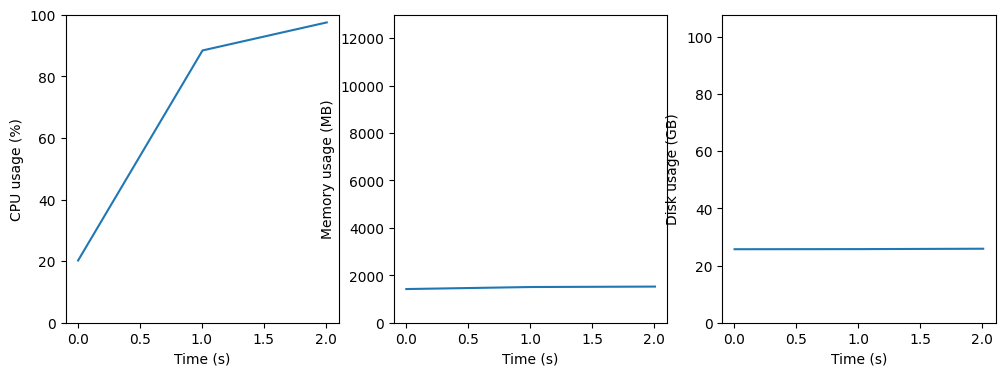

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446
Copying files from IDC buckets..
Done in 1.63713 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446.nii.gz 
/content/Inference/1 : decoded 1834994 bytes 
Done in 42.205 seconds.
Compressed 232433102 bytes into 1526479 bytes ==> 0.66%


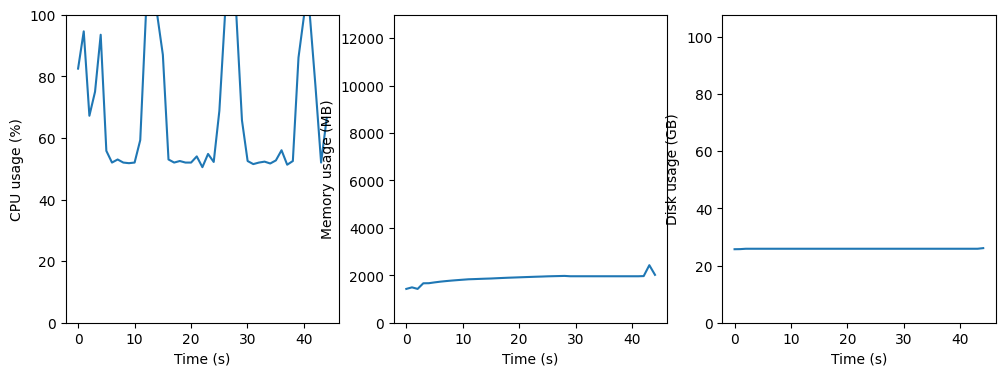

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343
Copying files from IDC buckets..
Done in 1.45016 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343.nii.gz.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343.nii.gz.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343.nii.gz not found!
Done in 0.118606 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.20

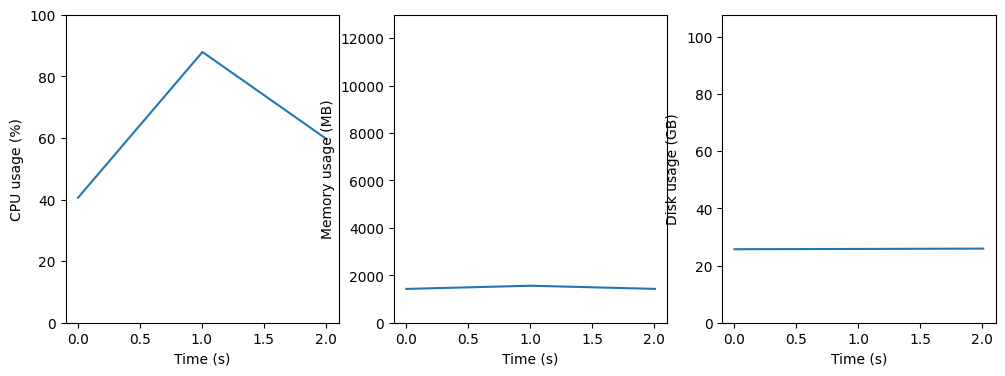

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524
Copying files from IDC buckets..
Done in 1.45133 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524.nii.gz 
/content/Inference/1 : decoded 2458062 bytes 
Done in 98.6869 seconds.
Compressed 331895790 bytes into 2065403 bytes ==> 0.62%


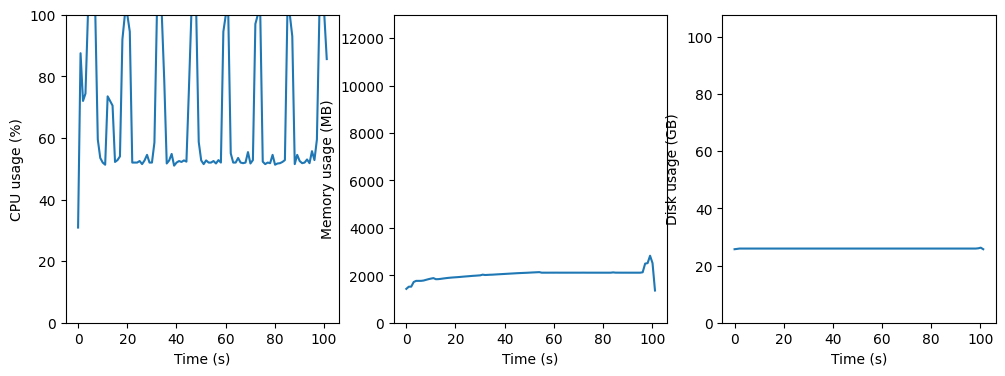

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684408755057011874628
Copying files from IDC buckets..
Done in 1.44512 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684408755057011874628/1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684408755057011874628.nii.gz 
/content/Inference/1 : decoded 1984430 bytes 
Done in 78.6684 seconds.
Compressed 311713596 bytes into 1964982 bytes ==> 0.63%


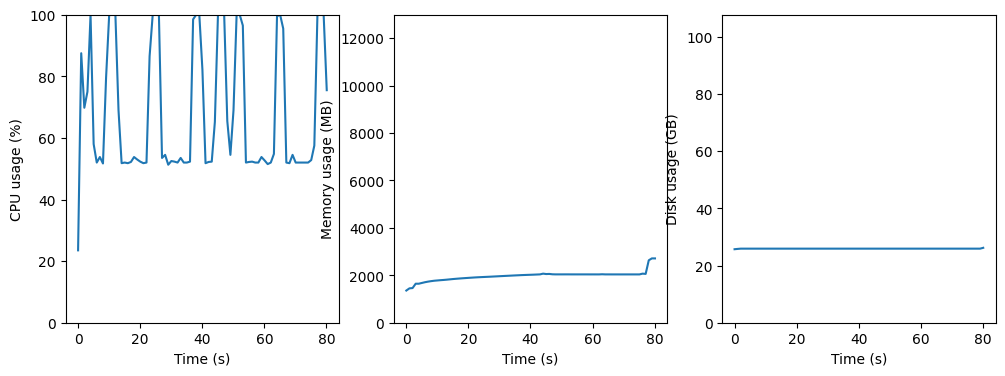

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843
Copying files from IDC buckets..
Done in 1.93273 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843.nii.gz 
/content/Inference/1 : decoded 2692746 bytes 
Done in 124.315 seconds.
Compressed 364529024 bytes into 2258547 bytes ==> 0.62%


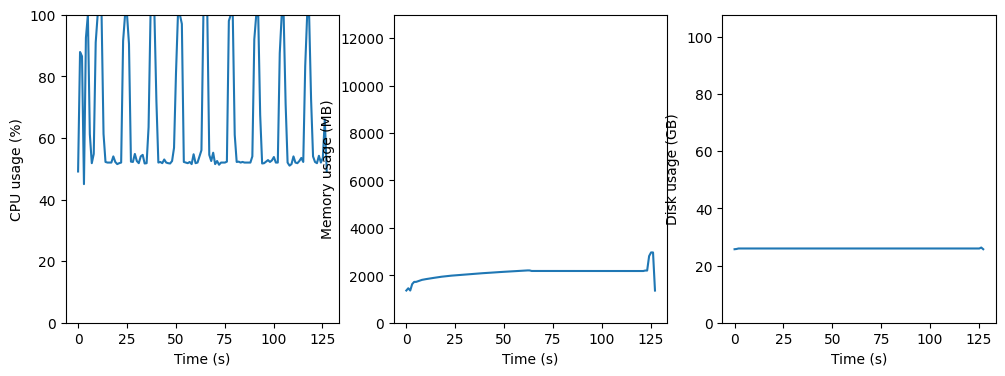

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.123701842413778227188879973411
Copying files from IDC buckets..
Done in 2.55966 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.123701842413778227188879973411/1.3.6.1.4.1.14519.5.2.1.7009.9004.123701842413778227188879973411.nii.gz 
/content/Inference/1 : decoded 2313280 bytes 
Done in 110.713 seconds.
Compressed 335900402 bytes into 2073823 bytes ==> 0.62%


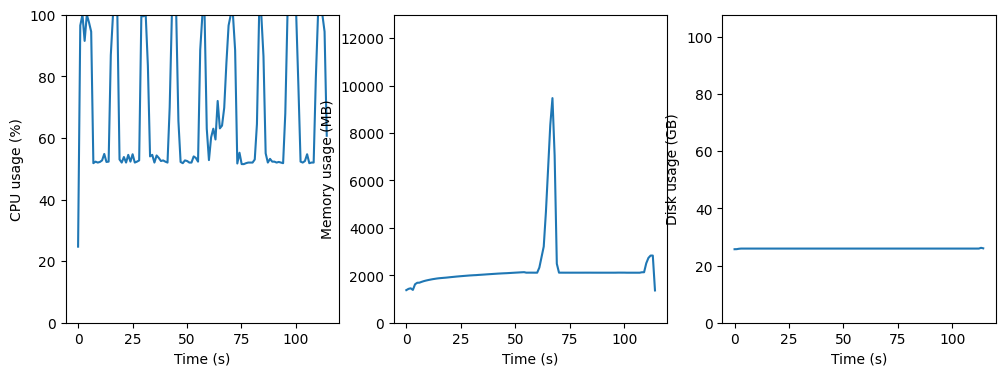

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.329620576698026033387022542648
Copying files from IDC buckets..
Done in 1.53533 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.329620576698026033387022542648/1.3.6.1.4.1.14519.5.2.1.7009.9004.329620576698026033387022542648.nii.gz 
/content/Inference/1 : decoded 2361261 bytes 
Done in 64.4361 seconds.
Compressed 284583292 bytes into 1886383 bytes ==> 0.66%


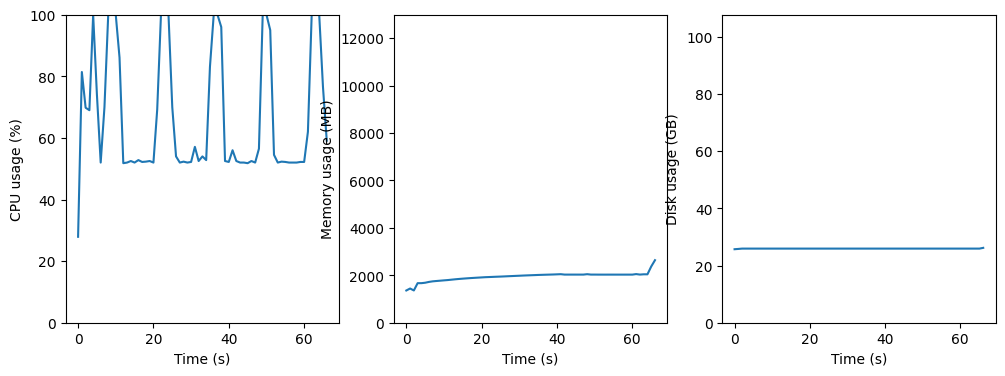

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.243502325940428446855263601476
Copying files from IDC buckets..
Done in 1.53116 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.243502325940428446855263601476/1.3.6.1.4.1.14519.5.2.1.7009.9004.243502325940428446855263601476.nii.gz 
/content/Inference/1 : decoded 2088420 bytes 
Done in 93.8446 seconds.
Compressed 338421570 bytes into 2131859 bytes ==> 0.63%


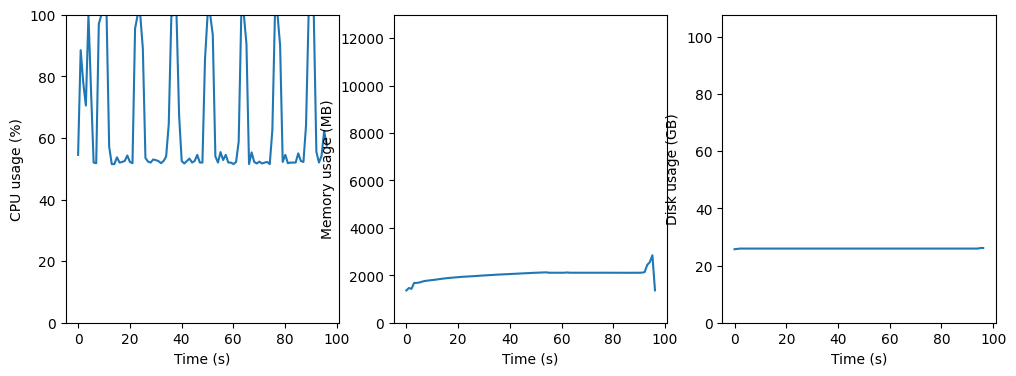

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.927959013573163594466065252924
Copying files from IDC buckets..
Done in 1.45362 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.927959013573163594466065252924/1.3.6.1.4.1.14519.5.2.1.7009.9004.927959013573163594466065252924.nii.gz 
/content/Inference/1 : decoded 2394658 bytes 
Done in 82.3082 seconds.
Compressed 307290906 bytes into 2028298 bytes ==> 0.66%


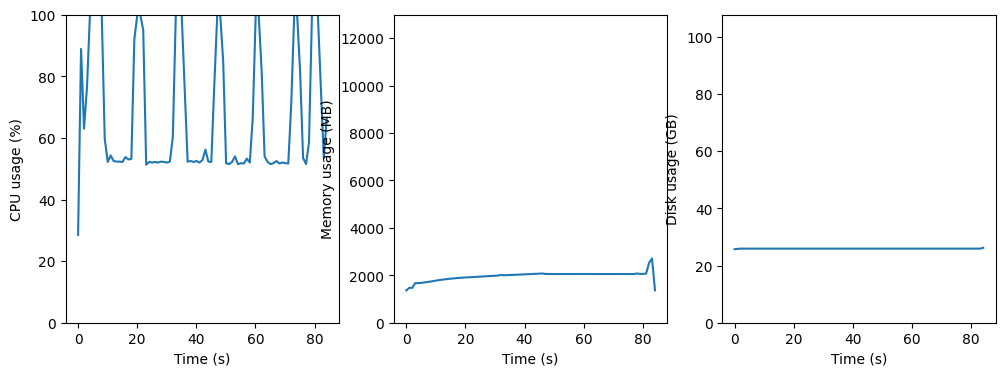

In [34]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimage, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [35]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051092643754602019853/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446/1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356655156695279614446.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775640067845998082343/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524/1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136395351005883778524.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684408755057011874628/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684408755057011874628/1.3.6.1.4.1.14519.5.2.1.7009.9004.3360829

###Utilization Metrics

In [36]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 30639 bytes into 9033 bytes ==> 29.48%


,SeriesInstanceUID,itkimage2segimage_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.212627601051...,0.121042,0.123052,"[[[20.2, 88.4, 97.5]]]","[[[1419.59375, 1505.27734375, 1523.38671875]]]",[12985.546875],"[[[25.705886840820312, 25.742774963378906, 25....",107.715084,0.217885
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.315930921356...,42.204961,0.221529,"[[[82.5, 94.6, 67.2, 75.0, 93.5, 55.8, 52.0, 5...","[[[1426.0078125, 1491.29296875, 1425.86328125,...",[12985.546875],"[[[25.70587921142578, 25.740619659423828, 25.8...",107.715084,0.217885
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.200791545775...,0.118606,0.122031,"[[[40.6, 87.9, 59.6]]]","[[[1425.21484375, 1559.625, 1427.1484375]]]",[12985.546875],"[[[25.70586395263672, 25.805374145507812, 25.9...",107.715084,0.217885
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.100071137136...,98.686929,0.322148,"[[[30.9, 87.5, 72.0, 74.4, 100.0, 100.0, 100.0...","[[[1427.2734375, 1518.36328125, 1521.2734375, ...",[12985.546875],"[[[25.70587921142578, 25.814247131347656, 25.9...",107.715084,0.217885
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.336082917684...,78.668444,0.223151,"[[[23.5, 87.5, 69.8, 75.0, 100.0, 58.0, 52.0, ...","[[[1357.29296875, 1449.04296875, 1461.26171875...",[12985.546875],"[[[25.705955505371094, 25.814205169677734, 25....",107.715084,0.217885
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465...,124.315008,0.220875,"[[[49.1, 87.9, 86.5, 45.0, 92.5, 100.0, 61.2, ...","[[[1357.95703125, 1453.09765625, 1358.09765625...",[12985.546875],"[[[25.706241607666016, 25.785541534423828, 25....",107.715084,0.217885
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.123701842413...,110.713074,0.218544,"[[[24.7, 96.5, 100.0, 91.5, 100.0, 97.5, 94.5,...","[[[1374.296875, 1427.6015625, 1452.0078125, 13...",[12985.546875],"[[[25.706356048583984, 25.727920532226562, 25....",107.715084,0.217885
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.329620576698...,64.436055,0.220180,"[[[27.9, 81.4, 69.8, 69.0, 100.0, 74.0, 52.0, ...","[[[1359.29296875, 1442.16015625, 1360.38671875...",[12985.546875],"[[[25.706565856933594, 25.80563735961914, 25.9...",107.715084,0.217885
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.243502325940...,93.844635,0.223390,"[[[54.5, 88.5, 77.9, 70.5, 100.0, 75.4, 52.0, ...","[[[1359.8359375, 1463.859375, 1428.32421875, 1...",[12985.546875],"[[[25.7064208984375, 25.81057357788086, 25.933...",107.715084,0.217885
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.927959013573...,82.308219,0.223070,"[[[28.5, 88.9, 63.0, 76.4, 100.0, 100.0, 100.0...","[[[1362.81640625, 1470.64453125, 1471.12890625...",[12985.546875],"[[[25.706844329833984, 25.817611694335938, 25....",107.715084,0.217885
